# **Classification Task**

In [135]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Data Preprocessing and Exploratory Data Analysis

In [136]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings("ignore")

# Load dataset

In [137]:
# Load the dataset
file_path = "/content/drive/MyDrive/AI Coursework/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(file_path)

df.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [138]:
#identify the number of rows and columns in the dataset.
rows, cols = df.shape
print(f"Number of rows: {rows}, Number of columns: {cols}")

Number of rows: 5110, Number of columns: 12


In [139]:
print("\nSummary Statistics:")
df.describe()


Summary Statistics:


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [140]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


## Handeling missing values

In [141]:
# Check for missing values
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


In [142]:
#To fill in value using median
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

In [143]:
# drop the 'id' column. it is a unique identifier, which has no predictive power.
df = df.drop('id', axis=1)

In [144]:
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


In [145]:
print("Columns after cleaning:")
df.columns

Columns after cleaning:


Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [146]:
print(f"Dataset shape after cleaning: {df.shape}")

Dataset shape after cleaning: (5110, 11)


In [147]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
encoder = LabelEncoder()

# Encode categorical variables
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_columns:
    df[col] = encoder.fit_transform(df[col].astype(str))

# Preview the dataset after encoding
print("Dataset after encoding:")
df.head()

Dataset after encoding:


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,0,61.0,0,0,1,3,0,202.21,28.1,2,1
2,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,0,79.0,1,0,1,3,0,174.12,24.0,2,1


# EDA

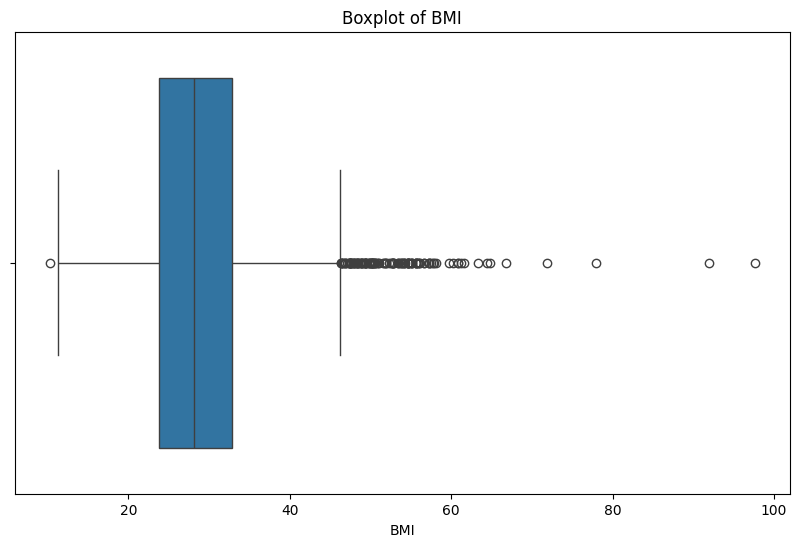

Outliers in 'bmi' column:
       bmi
21    48.9
66    47.5
113   56.6
254   50.1
258   54.6
...    ...
4906  54.1
4952  56.6
5009  49.5
5057  47.6
5103  46.9

[126 rows x 1 columns]

There are outliers present in the BMI data.


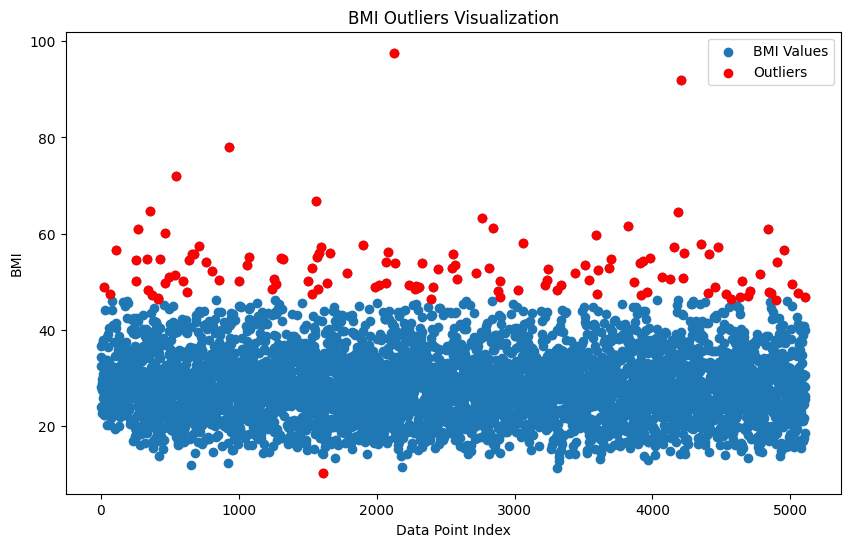

In [148]:
# visualise using scatterplot, the outlier of bmi also provide a  clear instruction if there is outlier or not

# Calculate Q1, Q3, and IQR for BMI
Q1_bmi = df['bmi'].quantile(0.25)
Q3_bmi = df['bmi'].quantile(0.75)
IQR_bmi = Q3_bmi - Q1_bmi

# Define bounds for BMI outliers
lower_bound_bmi = Q1_bmi - 1.5 * IQR_bmi
upper_bound_bmi = Q3_bmi + 1.5 * IQR_bmi

# Identify BMI outliers
bmi_outliers = df[(df['bmi'] < lower_bound_bmi) | (df['bmi'] > upper_bound_bmi)]

# Create the boxplot for BMI
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['bmi'])
plt.title('Boxplot of BMI')
plt.xlabel('BMI')
plt.show()

# Print BMI outlier information and visualize them
if len(bmi_outliers) > 0:
    print("Outliers in 'bmi' column:")
    print(bmi_outliers[['bmi']])
    print("\nThere are outliers present in the BMI data.")

    # Visualize BMI outliers using a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df['bmi'], label='BMI Values')
    plt.scatter(bmi_outliers.index, bmi_outliers['bmi'], color='red', label='Outliers')
    plt.title('BMI Outliers Visualization')
    plt.xlabel('Data Point Index')
    plt.ylabel('BMI')
    plt.legend()
    plt.show()
else:
    print("\nNo outliers detected in the BMI data.")

In [149]:
# prompt: generate a code to remove outliers from the bmi column

# Calculate the first quartile (Q1) and third quartile (Q3) for the 'bmi' column
Q1 = df['bmi'].quantile(0.25)
Q3 = df['bmi'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers from the DataFrame
df_no_outliers = df[(df['bmi'] >= lower_bound) & (df['bmi'] <= upper_bound)]

# Print the number of outliers removed
outliers_removed = len(df) - len(df_no_outliers)
print(f"Number of outliers removed from 'bmi' column: {outliers_removed}")

# Now 'df_no_outliers' contains the data with outliers removed from the 'bmi' column


Number of outliers removed from 'bmi' column: 126


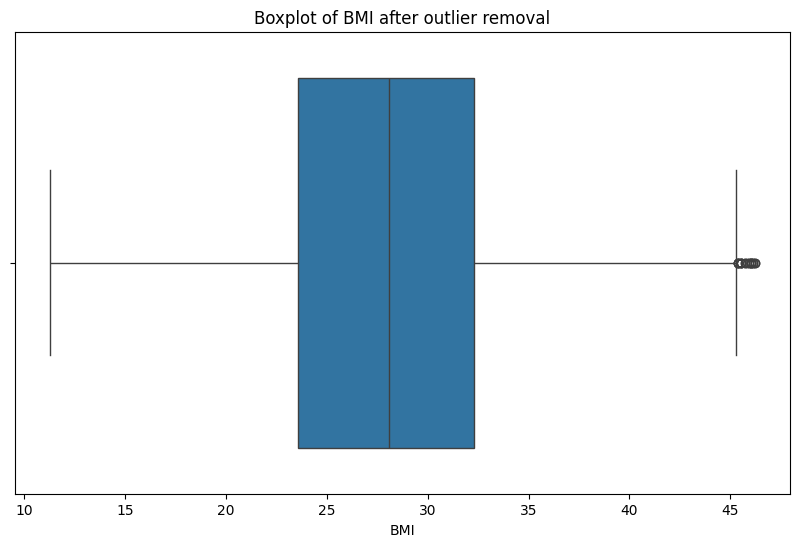

In [150]:
# Create the boxplot for BMI after outlier removal
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_no_outliers['bmi'])
plt.title('Boxplot of BMI after outlier removal')
plt.xlabel('BMI')
plt.show()


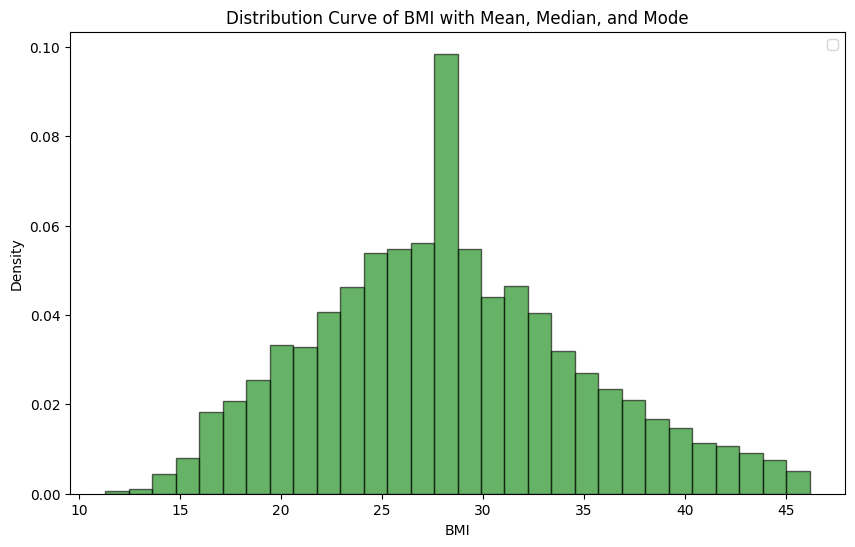

In [151]:
# BMI Distribution with Mean, Median, and Mode
# Remove rows where BMI is 'N/A'
data = df_no_outliers[df_no_outliers['bmi'] != 'N/A']


# Calculate mean, median, and mode
mean_bmi = data['bmi'].mean()
median_bmi = data['bmi'].median()
mode_bmi = data['bmi'].mode()[0]

# Plot the distribution curve
plt.figure(figsize=(10, 6))
plt.hist(data['bmi'], bins=30, density=True, alpha=0.6, color='g', edgecolor='black')

# Add labels and title
plt.xlabel('BMI')
plt.ylabel('Density')
plt.title('Distribution Curve of BMI with Mean, Median, and Mode')
plt.legend()

# Show the plot
plt.show()

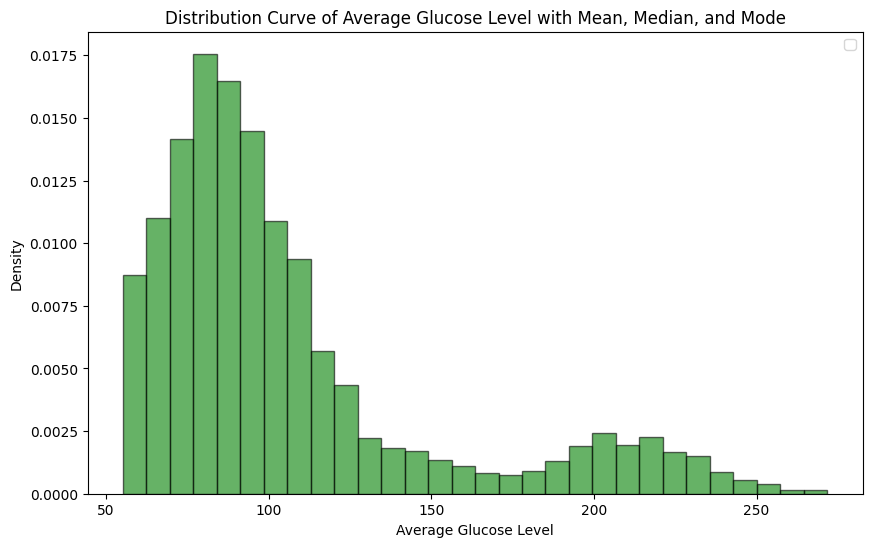

In [201]:
# plot Distribution Curve of avg_glucose_level with Mean, Median, and Mode

# Calculate mean, median, and mode
mean_glucose = df_no_outliers['avg_glucose_level'].mean()
median_glucose = df_no_outliers['avg_glucose_level'].median()
mode_glucose = df_no_outliers['avg_glucose_level'].mode()[0]

# Plot the distribution curve
plt.figure(figsize=(10, 6))
plt.hist(df['avg_glucose_level'], bins=30, density=True, alpha=0.6, color='g', edgecolor='black')

# Add labels and title
plt.xlabel('Average Glucose Level')
plt.ylabel('Density')
plt.title('Distribution Curve of Average Glucose Level with Mean, Median, and Mode')
plt.legend()

# Show the plot
plt.show()

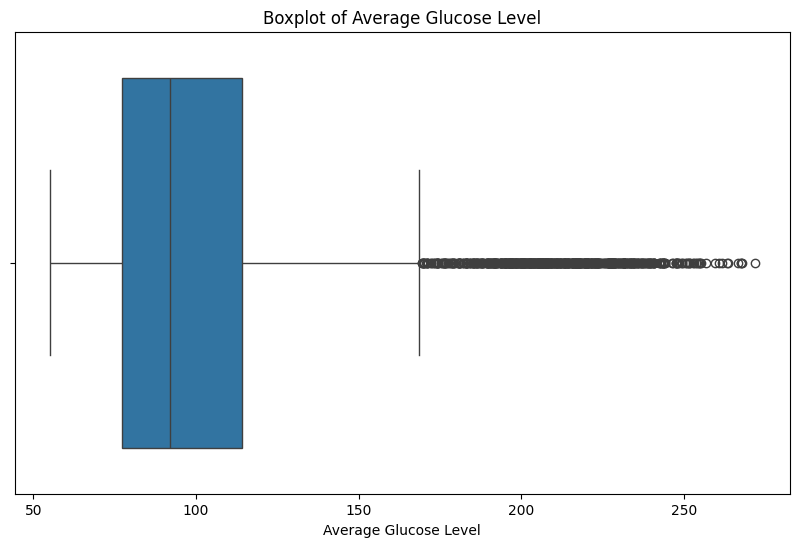

Outliers in 'avg_glucose_level' column:
      avg_glucose_level
0                228.69
1                202.21
3                171.23
4                174.12
5                186.21
...                 ...
5061             223.78
5062             211.58
5063             179.38
5064             193.88
5076             174.37

[594 rows x 1 columns]

There are outliers present in the average glucose level data.


In [153]:
# visualise using boxplot, the outlier of avg glucose level, also provide a  clear instruction if there is outlier or not

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate Q1, Q3, and IQR
Q1 = df_no_outliers['avg_glucose_level'].quantile(0.25)
Q3 = df_no_outliers['avg_glucose_level'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df_no_outliers[(df_no_outliers['avg_glucose_level'] < lower_bound) | (df_no_outliers['avg_glucose_level'] > upper_bound)]

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['avg_glucose_level'])
plt.title('Boxplot of Average Glucose Level')
plt.xlabel('Average Glucose Level')
plt.show()

# Print outlier information
if len(outliers) > 0:
    print("Outliers in 'avg_glucose_level' column:")
    print(outliers[['avg_glucose_level']])  # Print only the avg_glucose_level values
    print("\nThere are outliers present in the average glucose level data.")
else:
    print("\nNo outliers detected in the average glucose level data.")

In [154]:

# Calculate Q1, Q3, and IQR for 'avg_glucose_level'
Q1_glucose = df_no_outliers['avg_glucose_level'].quantile(0.25)
Q3_glucose = df_no_outliers['avg_glucose_level'].quantile(0.75)
IQR_glucose = Q3_glucose - Q1_glucose

# Define bounds for 'avg_glucose_level' outliers
lower_bound_glucose = Q1_glucose - 1.5 * IQR_glucose
upper_bound_glucose = Q3_glucose + 1.5 * IQR_glucose

# Remove outliers from the DataFrame
df_no_glucose_outliers = df_no_outliers[(df_no_outliers['avg_glucose_level'] >= lower_bound_glucose) & (df_no_outliers['avg_glucose_level'] <= upper_bound_glucose)]

# Print the number of outliers removed
glucose_outliers_removed = len(df) - len(df_no_glucose_outliers)
print(f"Number of outliers removed from 'avg_glucose_level' column: {glucose_outliers_removed}")

# Now 'df_no_glucose_outliers' contains the data with outliers removed from the 'avg_glucose_level' column


Number of outliers removed from 'avg_glucose_level' column: 720


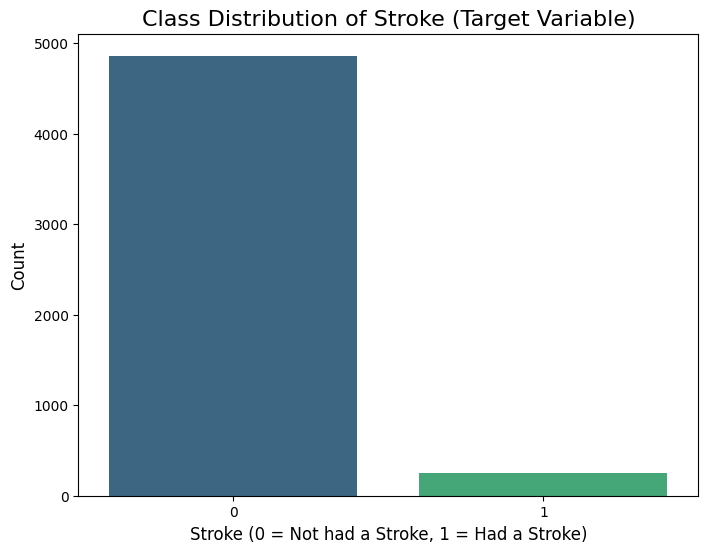

In [155]:
# Countplot for class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='stroke', palette='viridis')

# Adding titles and labels
plt.title('Class Distribution of Stroke (Target Variable)', fontsize=16)
plt.xlabel('Stroke (0 = Not had a Stroke, 1 = Had a Stroke)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


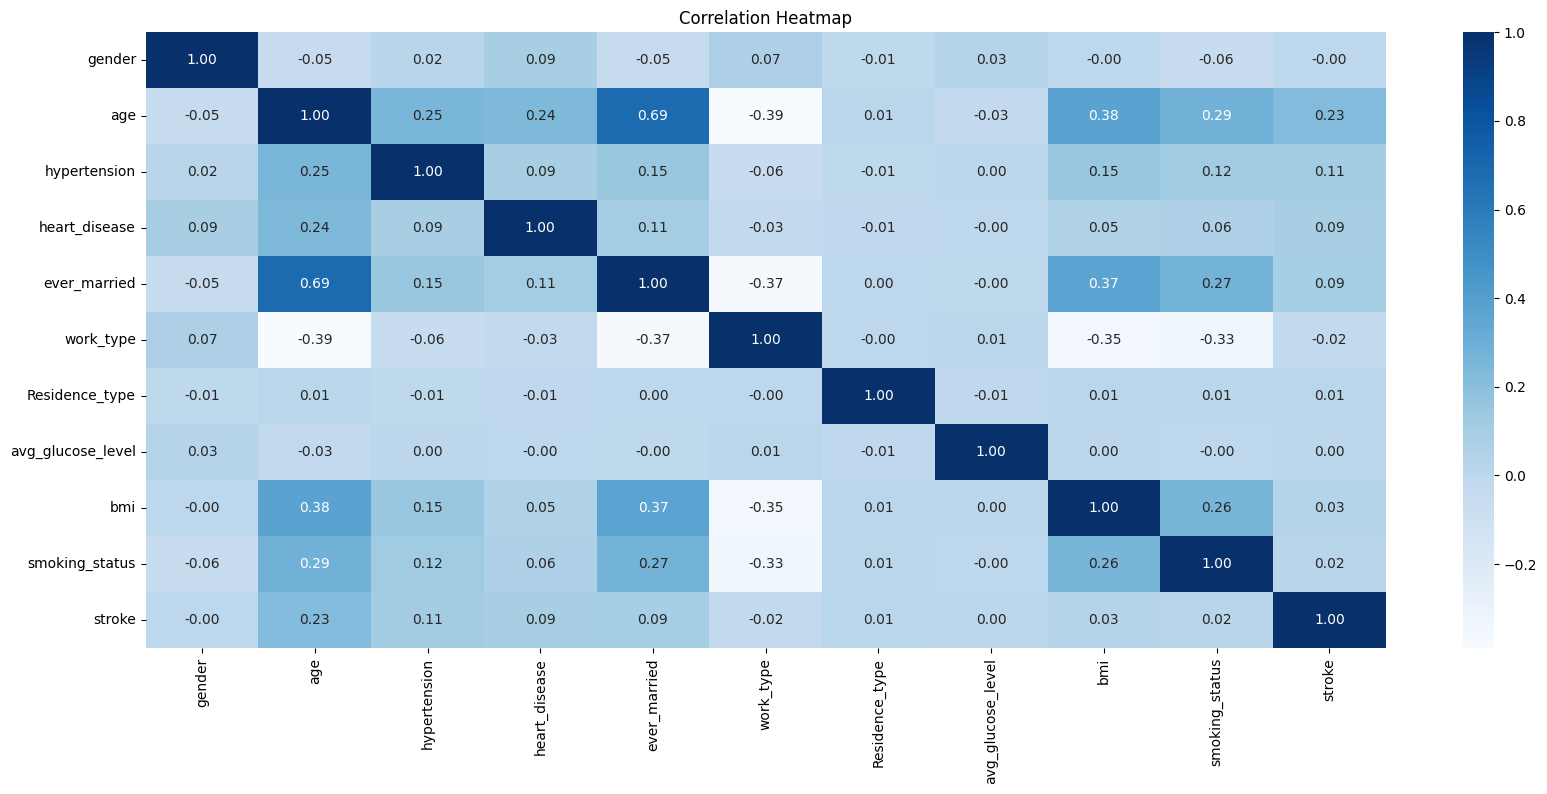

In [156]:
plt.figure(figsize=(20, 8))
sns.heatmap(df_no_glucose_outliers.corr(), annot=True,cmap='Blues', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

## Data separation

In [157]:
#Creating a copy of the dataframe without glucose outliers to preserve the original data.
df_final = df_no_glucose_outliers.copy()

In [158]:
# Separate features (X) and target (y)
X = df_final.drop('stroke', axis=1)
y = df_final['stroke']

## One Hot encoder

In [159]:
# One-hot encode the target variable
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_one_hot = one_hot_encoder.fit_transform(y.values.reshape(-1, 1))


In [160]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [161]:
# Apply SMOTE for class balancing
smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [162]:
unique_classes = np.unique(y_resampled)
class_weights = compute_class_weight(class_weight="balanced", classes=unique_classes, y=y_resampled)
class_weights = dict(zip(unique_classes, class_weights))  # Creates a dictionary mapping classes to weights

In [163]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [164]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Building Model from scratch

In [165]:
def sigmoid(x):
  import numpy as np
  y = 1 / (1 + np.exp(-x))
  return y

In [166]:
def log_loss(y_true, y_pred):
  import numpy as np
  # Ensure y_pred is clipped to avoid log(0)
  y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
  loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
  return loss

In [167]:
def cost_function(y_true, y_pred):
    assert len(y_true) == len(y_pred), "Length of true values and length of predicted values do not match"
    n = len(y_true)  # Get the number of data points
    loss_vec = [log_loss(y_true[i], y_pred[i]) for i in range(n)] # Calculate log loss for each data point
    cost = sum(loss_vec) / n  # Calculate average log loss (cost)
    return cost

In [168]:
def costfunction_logreg(X, y, w, b):
    m, n = X.shape
    assert len(y) == m, "Number of feature observations and number of target observations do not match."
    assert len(w) == n, "Number of features and number of weight parameters do not match."

    # Compute z using np.dot
    z = np.dot(X, w) + b  # Matrix-vector multiplication and adding bias

    # Compute predictions using logistic function (sigmoid)
    y_pred = 1 / (1 + np.exp(-z)) # This line was missing

    # Compute the cost using the cost function
    cost = -np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) / m

    return cost


In [169]:
def compute_gradient(X, y, w, b):
    n, d = X.shape  # X has shape (n, d)
    assert len(y) == n, f"Expected y to have {n} elements, but got {len(y)}"
    assert len(w) == d, f"Expected w to have {d} elements, but got {len(w)}"

    # Compute predictions using logistic function (sigmoid)
    y_pred = sigmoid(np.dot(X, w) + b)  # Compute z = X * w + b

    # Compute gradients
    grad_w = np.dot(X.T, (y_pred - y)) / n  # Gradient w.r.t weights, shape (d,)
    grad_b = np.sum(y_pred - y) / n          # Gradient w.r.t bias, scalar

    return grad_w, grad_b

In [170]:
def gradient_descent(X, y, w, b, alpha, n_iter, show_cost=False, show_params=True):
    n, d = X.shape
    assert len(y) == n, "Number of observations in X and y do not match"
    assert len(w) == d, "Number of features in X and w do not match"

    cost_history = []
    params_history = []

    for i in range(n_iter):
        # Compute gradients
        grad_w, grad_b = compute_gradient(X, y, w, b) # Calling the compute_gradient function to get gradients

        # Update weights and bias
        w -= alpha * grad_w  # Updating weights using gradients and learning rate
        b -= alpha * grad_b  # Updating bias using gradients and learning rate

        # Compute cost
        cost = costfunction_logreg(X, y, w, b)

        # Store cost and parameters
        cost_history.append(cost)
        params_history.append((w.copy(), b))

        # Optionally print cost and parameters
        if show_cost and (i % 100 == 0 or i == n_iter - 1):
            print(f"Iteration {i}: Cost = {cost:.6f}")
        if show_params and (i % 100 == 0 or i == n_iter - 1):
            print(f"Iteration {i}: w = {w}, b = {b:.6f}")

    return w, b, cost_history, params_history


In [171]:
def prediction(X, w, b, threshold=0.5):
    # Compute the predicted probabilities using the logistic function
    y_test_prob = sigmoid(np.dot(X, w) + b)

    # Classify based on the threshold
    y_pred = (y_test_prob >= threshold).astype(int)

    return y_pred

In [172]:

def evaluate_classification(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))  # True Positives
    TN = np.sum((y_true == 0) & (y_pred == 0))  # True Negatives
    FP = np.sum((y_true == 0) & (y_pred == 1))  # False Positives
    FN = np.sum((y_true == 1) & (y_pred == 0))  # False Negatives

    # Confusion matrix
    confusion_matrix = np.array([[TN, FP],
                                  [FN, TP]])

    # Precision, recall, and F1-score with safe handling of zero division
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0  # Recall calculation
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0  # F1-score calculation

    # Ensure metrics are floats
    precision = float(precision)
    recall = float(recall)
    f1_score = float(f1_score)

    # Return metrics
    return confusion_matrix, precision, recall, f1_score

In [173]:
# Initialize parameters
n_features = X_train.shape[1]
w_initial = np.zeros(n_features) # Initialize weights to zero
b_initial = 0.0             # Initialize bias to zero
alpha = 0.01                # Learning rate
n_iter = 1000              # Number of iterations

# Train the model using gradient descent
w_final, b_final, cost_history, params_history = gradient_descent(X_train_scaled, y_train, w_initial, b_initial, alpha, n_iter, show_cost=True, show_params=False)


Iteration 0: Cost = 0.691736
Iteration 100: Cost = 0.598013
Iteration 200: Cost = 0.553591
Iteration 300: Cost = 0.528440
Iteration 400: Cost = 0.512392
Iteration 500: Cost = 0.501321
Iteration 600: Cost = 0.493264
Iteration 700: Cost = 0.487174
Iteration 800: Cost = 0.482437
Iteration 900: Cost = 0.478669
Iteration 999: Cost = 0.475645


In [174]:
# Optionally, make predictions on the test set and evaluate the classifier:
y_pred_test = prediction(X_test_scaled, w_final, b_final)
y_pred_train = prediction(X_train_scaled, w_final, b_final)
conf_matrix, precision, recall, f1 = evaluate_classification(y_test, y_pred_test)

In [175]:
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Confusion Matrix:
[[635 207]
 [148 700]]
Precision: 0.7718, Recall: 0.8255, F1-score: 0.7977


In [176]:
# Model Evaluation on the Test Set
print("\n Model Evaluation on Train Set:")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.3f}\n")
print("Classification Report:\n", classification_report(y_train, y_pred_train))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))


 Model Evaluation on Train Set:
Accuracy: 0.781

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.72      0.77      3383
           1       0.75      0.84      0.79      3377

    accuracy                           0.78      6760
   macro avg       0.79      0.78      0.78      6760
weighted avg       0.79      0.78      0.78      6760

Confusion Matrix:
 [[2439  944]
 [ 536 2841]]


In [177]:
# Model Evaluation on the Test Set
print("\n Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.3f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))


 Model Evaluation on Test Set:
Accuracy: 0.790

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.75      0.78       842
           1       0.77      0.83      0.80       848

    accuracy                           0.79      1690
   macro avg       0.79      0.79      0.79      1690
weighted avg       0.79      0.79      0.79      1690

Confusion Matrix:
 [[635 207]
 [148 700]]


# Model 1: Random Forest Classifier

In [178]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)  # Use y_train directly if it contains binary labels


RandomForestClassifier(class_weight='balanced', random_state=42)

In [179]:
# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

In [180]:
# Model Evaluation
print("\n Random Forest Model Evaluation on Train Set:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_rf):.2f}")
print("\nClassification Report:\n", classification_report(y_train, y_train_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_train, y_train_pred_rf))


 Random Forest Model Evaluation on Train Set:
Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3383
           1       1.00      1.00      1.00      3377

    accuracy                           1.00      6760
   macro avg       1.00      1.00      1.00      6760
weighted avg       1.00      1.00      1.00      6760


Confusion Matrix:
 [[3383    0]
 [   0 3377]]


In [181]:
# Model Evaluation
print("\n Random Forest Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_rf):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred_rf))


 Random Forest Model Evaluation on Test Set:
Accuracy: 0.97

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       842
           1       0.97      0.98      0.97       848

    accuracy                           0.97      1690
   macro avg       0.97      0.97      0.97      1690
weighted avg       0.97      0.97      0.97      1690


Confusion Matrix:
 [[814  28]
 [ 19 829]]


# Model 2: Logistic Regression




In [182]:
log_reg_model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)

# Fit the model on the training data.
log_reg_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [183]:
# Make predictions on the test set.
y_test_pred_logreg = log_reg_model.predict(X_test_scaled)
y_train_pred_logreg = log_reg_model.predict(X_train_scaled)

In [184]:
# Evaluate the performance of the logistic regression model on train set

print(" Logistic Regression Model Evaluation on Train Set:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_logreg):.2f}\n")
print("Classification Report:\n", classification_report(y_train, y_train_pred_logreg))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred_logreg))

 Logistic Regression Model Evaluation on Train Set:
Accuracy: 0.79

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.75      0.78      3383
           1       0.77      0.82      0.79      3377

    accuracy                           0.79      6760
   macro avg       0.79      0.79      0.79      6760
weighted avg       0.79      0.79      0.79      6760

Confusion Matrix:
 [[2534  849]
 [ 598 2779]]


In [185]:
# Evaluate the performance of the logistic regression model on test set

print(" Logistic Regression Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_logreg):.2f}\n")
print("Classification Report:\n", classification_report(y_test, y_test_pred_logreg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_logreg))

 Logistic Regression Model Evaluation on Test Set:
Accuracy: 0.79

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79       842
           1       0.79      0.81      0.80       848

    accuracy                           0.79      1690
   macro avg       0.79      0.79      0.79      1690
weighted avg       0.79      0.79      0.79      1690

Confusion Matrix:
 [[659 183]
 [164 684]]


The Random Forest model performed significantly better than the Logistic Regression model based on multiple evaluation metrics:

* Accuracy:

Logistic Regression: 0.79

Random Forest: 0.97

 Random Forest has higher accuracy.

* Precision, Recall, and F1-score:

Random Forest has higher precision, recall, and F1-scores for both classes (0 and 1), meaning it is more effective at correctly classifying both positive and negative cases.
Random Forest dominates in all these metrics.

* Confusion Matrix:

Logistic Regression had 183 false positives and 164 false negatives.

Random Forest had only 28 false positives and 19 false negatives.

Random Forest makes fewer classification errors.

Thus, the Random Forest model demonstrates a much stronger performance for this classification task compared to the Logistic Regression model.

# Hyperparameter optimization



## Hyperparameter Optimization: Random Forest




In [186]:
rf_param_dist = {
"n_estimators": [50, 100, 200, 300, 400],
"max_depth": [None, 10, 20, 30, 40],
"min_samples_split": [2, 5, 10],
"min_samples_leaf": [1, 2, 4],
"max_features": ["sqrt", "log2", None],
"criterion": ["gini", "entropy"],
"bootstrap": [True, False]
}

In [187]:
rf_model = RandomForestClassifier(random_state=42, class_weight="balanced")

In [188]:
random_search = RandomizedSearchCV(
rf_model,
param_distributions=rf_param_dist,
n_iter=50,
cv=5,
scoring="accuracy",
n_jobs=-1,
random_state=42
)

In [189]:
random_search.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30, 40],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300,
                                                         400]},
                   random_state=42, scoring='accuracy')

In [190]:
best_rf_model_rand = random_search.best_estimator_
print("The best Random Forest Parameters:", random_search.best_params_)

The best Random Forest Parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 40, 'criterion': 'entropy', 'bootstrap': False}


In [191]:
y_test_pred_rf_best = best_rf_model_rand.predict(X_test_scaled)
print("\nBest Random Forest Model Evaluation after hyperparameter optimization:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_rf_best):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_rf_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred_rf_best))


Best Random Forest Model Evaluation after hyperparameter optimization:
Accuracy: 0.98

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       842
           1       0.98      0.98      0.98       848

    accuracy                           0.98      1690
   macro avg       0.98      0.98      0.98      1690
weighted avg       0.98      0.98      0.98      1690


Confusion Matrix:
 [[825  17]
 [ 18 830]]


## Hyperparameter Optimization: Logistic Regression


In [192]:
# Logistic Regression Hyperparameter Grid
log_reg_param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "solver": ["liblinear", "lbfgs"],
    "penalty": [ "l2"]
}

# Logistic Regression with GridSearchCV
log_reg_model = LogisticRegression(random_state=42, class_weight="balanced", max_iter=1000)
log_reg_grid_search = GridSearchCV(log_reg_model, log_reg_param_grid, cv=5, scoring="accuracy", n_jobs=-1)
log_reg_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='accuracy')

In [193]:

# Best parameters for Logistic Regression
best_log_reg_model = log_reg_grid_search.best_estimator_
print("Best Logistic Regression Parameters:", log_reg_grid_search.best_params_)

Best Logistic Regression Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


In [194]:
# Predictions
y_test_pred_log_reg_best = best_log_reg_model.predict(X_test)

# Evaluation
print("\nBest Logistic Regression Model Evaluation After Hyperparameter optimization:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_log_reg_best):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_log_reg_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred_log_reg_best))



Best Logistic Regression Model Evaluation After Hyperparameter optimization:
Accuracy: 0.80

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.79       842
           1       0.77      0.84      0.80       848

    accuracy                           0.80      1690
   macro avg       0.80      0.80      0.79      1690
weighted avg       0.80      0.80      0.79      1690


Confusion Matrix:
 [[635 207]
 [139 709]]


 The best hyperparameters for each model were:  

- **Random Forest:** `max_depth=None`, `min_samples_leaf=1`, `min_samples_split=2`, `n_estimators=200`  
- **Logistic Regression:** `C=1`, `penalty='l2'`, `solver='lbfgs'`  


#Feature Selection

## Feature Selection: Random Forest

In [195]:
# Use SelectFromModel to select features based on feature importances
selector = SelectFromModel(rf_model, threshold='median') # Select features with importance above the median
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)


# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

print("Selected Feature Indices:", selected_feature_indices)


# Get the names of selected features (if available)
selected_feature_names = X.columns[selected_feature_indices].tolist()
print("Selected Feature Names:", selected_feature_names)




Selected Feature Indices: [1 5 7 8 9]
Selected Feature Names: ['age', 'work_type', 'avg_glucose_level', 'bmi', 'smoking_status']


## Feature selection: Logistic Regression

In [196]:
selector_lr = SelectFromModel(log_reg_model, threshold='median')
X_train_selected_lr = selector_lr.fit_transform(X_train_scaled, y_train)
X_test_selected_lr = selector_lr.transform(X_test_scaled)

# Get the indices of the selected features
selected_feature_indices_lr = selector_lr.get_support(indices=True)

print("Selected Feature Indices (Logistic Regression):", selected_feature_indices_lr)

# Get the names of selected features
selected_feature_names_lr = X.columns[selected_feature_indices_lr].tolist()
print("Selected Feature Names (Logistic Regression):", selected_feature_names_lr)


Selected Feature Indices (Logistic Regression): [1 2 5 6 9]
Selected Feature Names (Logistic Regression): ['age', 'hypertension', 'work_type', 'Residence_type', 'smoking_status']


##Final Model(Random Forest Classifier) After Hyperparameter Optimization and Hyperparameter Tuning

In [197]:
final_rf_model = RandomForestClassifier(**random_search.best_params_, random_state=42, class_weight="balanced")

final_rf_model.fit(X_train_selected, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=40, max_features='log2',
                       min_samples_split=5, n_estimators=400, random_state=42)

In [198]:
# Make predictions on the test set using the final model
y_pred_test_final = final_rf_model.predict(X_test_selected)
y_pred_train_final = final_rf_model.predict(X_train_selected)

In [199]:
# Evaluate the final model
print("\nFinal Random Forest Model Evaluation for Train set:")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train_final):.2f}")
print("\nClassification Report:\n", classification_report(y_train, y_pred_train_final))
print("\nConfusion Matrix:\n", confusion_matrix(y_train, y_pred_train_final))


Final Random Forest Model Evaluation for Train set:
Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3383
           1       1.00      1.00      1.00      3377

    accuracy                           1.00      6760
   macro avg       1.00      1.00      1.00      6760
weighted avg       1.00      1.00      1.00      6760


Confusion Matrix:
 [[3383    0]
 [   0 3377]]


In [200]:
# Evaluate the final model
print("\nFinal Random Forest Model Evaluation For Test set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test_final):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_test_final))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test_final))


Final Random Forest Model Evaluation For Test set:
Accuracy: 0.95

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       842
           1       0.96      0.95      0.95       848

    accuracy                           0.95      1690
   macro avg       0.95      0.95      0.95      1690
weighted avg       0.95      0.95      0.95      1690


Confusion Matrix:
 [[805  37]
 [ 42 806]]


## Conclusion:
####The initial Random Forest model outperformed the final model, achieving 97% accuracy compared to 95% in the final version while maintaining perfect training accuracy (100%). It had higher precision, recall, and F1-scores across both classes, indicating better classification performance. The confusion matrix also showed fewer misclassifications in the initial model. While the final model may have been adjusted for better generalization, the initial model demonstrated superior predictive ability overall.
